In [190]:
import glob
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import scipy.stats as st
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from statsmodels.stats.anova import AnovaRM

# Load Data

In [2]:
files = []
files.extend(glob.glob('data/unidirectional/*.csv'))
files.extend(glob.glob('data/bidirectional/*.csv'))

print(f"Loaded {len(files)} files")

Loaded 36 files


In [ ]:
combined = pd.DataFrame(columns=["Participant","Condition","Response","Test Stim","Test Speed","Correct","Time"])
subjects = set()

for file in files:
    name = file[file.rfind('/')+1:][:3]
    subjects.add(name)

    match file:
        case file if 'unidirectional' in file:
            t_type = 'Unidirectional Adapt'
        case file if 'bidirectional' in file and 'noAdapt' not in file:
            t_type = 'Bidirectional Adapt'
        case _:
            t_type = 'No Adapt'

    participant_data = pd.read_csv(file, index_col=0)
    participant_data["Participant"] = name
    participant_data["Condition"] = t_type
    combined = pd.concat([combined, participant_data], axis=0)

subject_list = sorted(list(subjects))
combined.to_csv("./data/combined.csv")
combined.head()

/var/folders/38/cyy5p2n96d1fr3wzqvg05w4c0000gn/T/ipykernel_59595/3795372964.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([combined, participant_data], axis=0)


,Participant,Condition,Response,Test Stim,Test Speed,Correct,Time
0,nxn,Unidirectional Adapt,right,log,38.0,True,0.941106
1,nxn,Unidirectional Adapt,right,mirror,62.0,True,1.054182
2,nxn,Unidirectional Adapt,right,mirror,62.0,True,1.238950
3,nxn,Unidirectional Adapt,left,log,70.0,False,2.613170
4,nxn,Unidirectional Adapt,right,mirror,70.0,True,0.793902


In [306]:
# Subjects that adapted to CCW tested speeds [-70, 10] in the unidirectional condition.
# This is manually checked by looking at the unidirectional data.
dirmap = {
    "ccw": ["jdg", "nst", "nxs", "mxw", "tee", "ksm"],
    "cw": ["anb", "kxt", "mjl", "nxn", "txd", "sxk"],
}

reverse_dirmap = {}
for k, v in dirmap.items():
    for s in v:
        reverse_dirmap[s] = k

# Psychometric Function Fitting

In [317]:
# This is fitting Gaussian CDF (mu and sigma) with floor and ceiling parameters
def f(x, m, s, a, b):
    return a + (b - a) * st.norm.cdf(x, m, s)

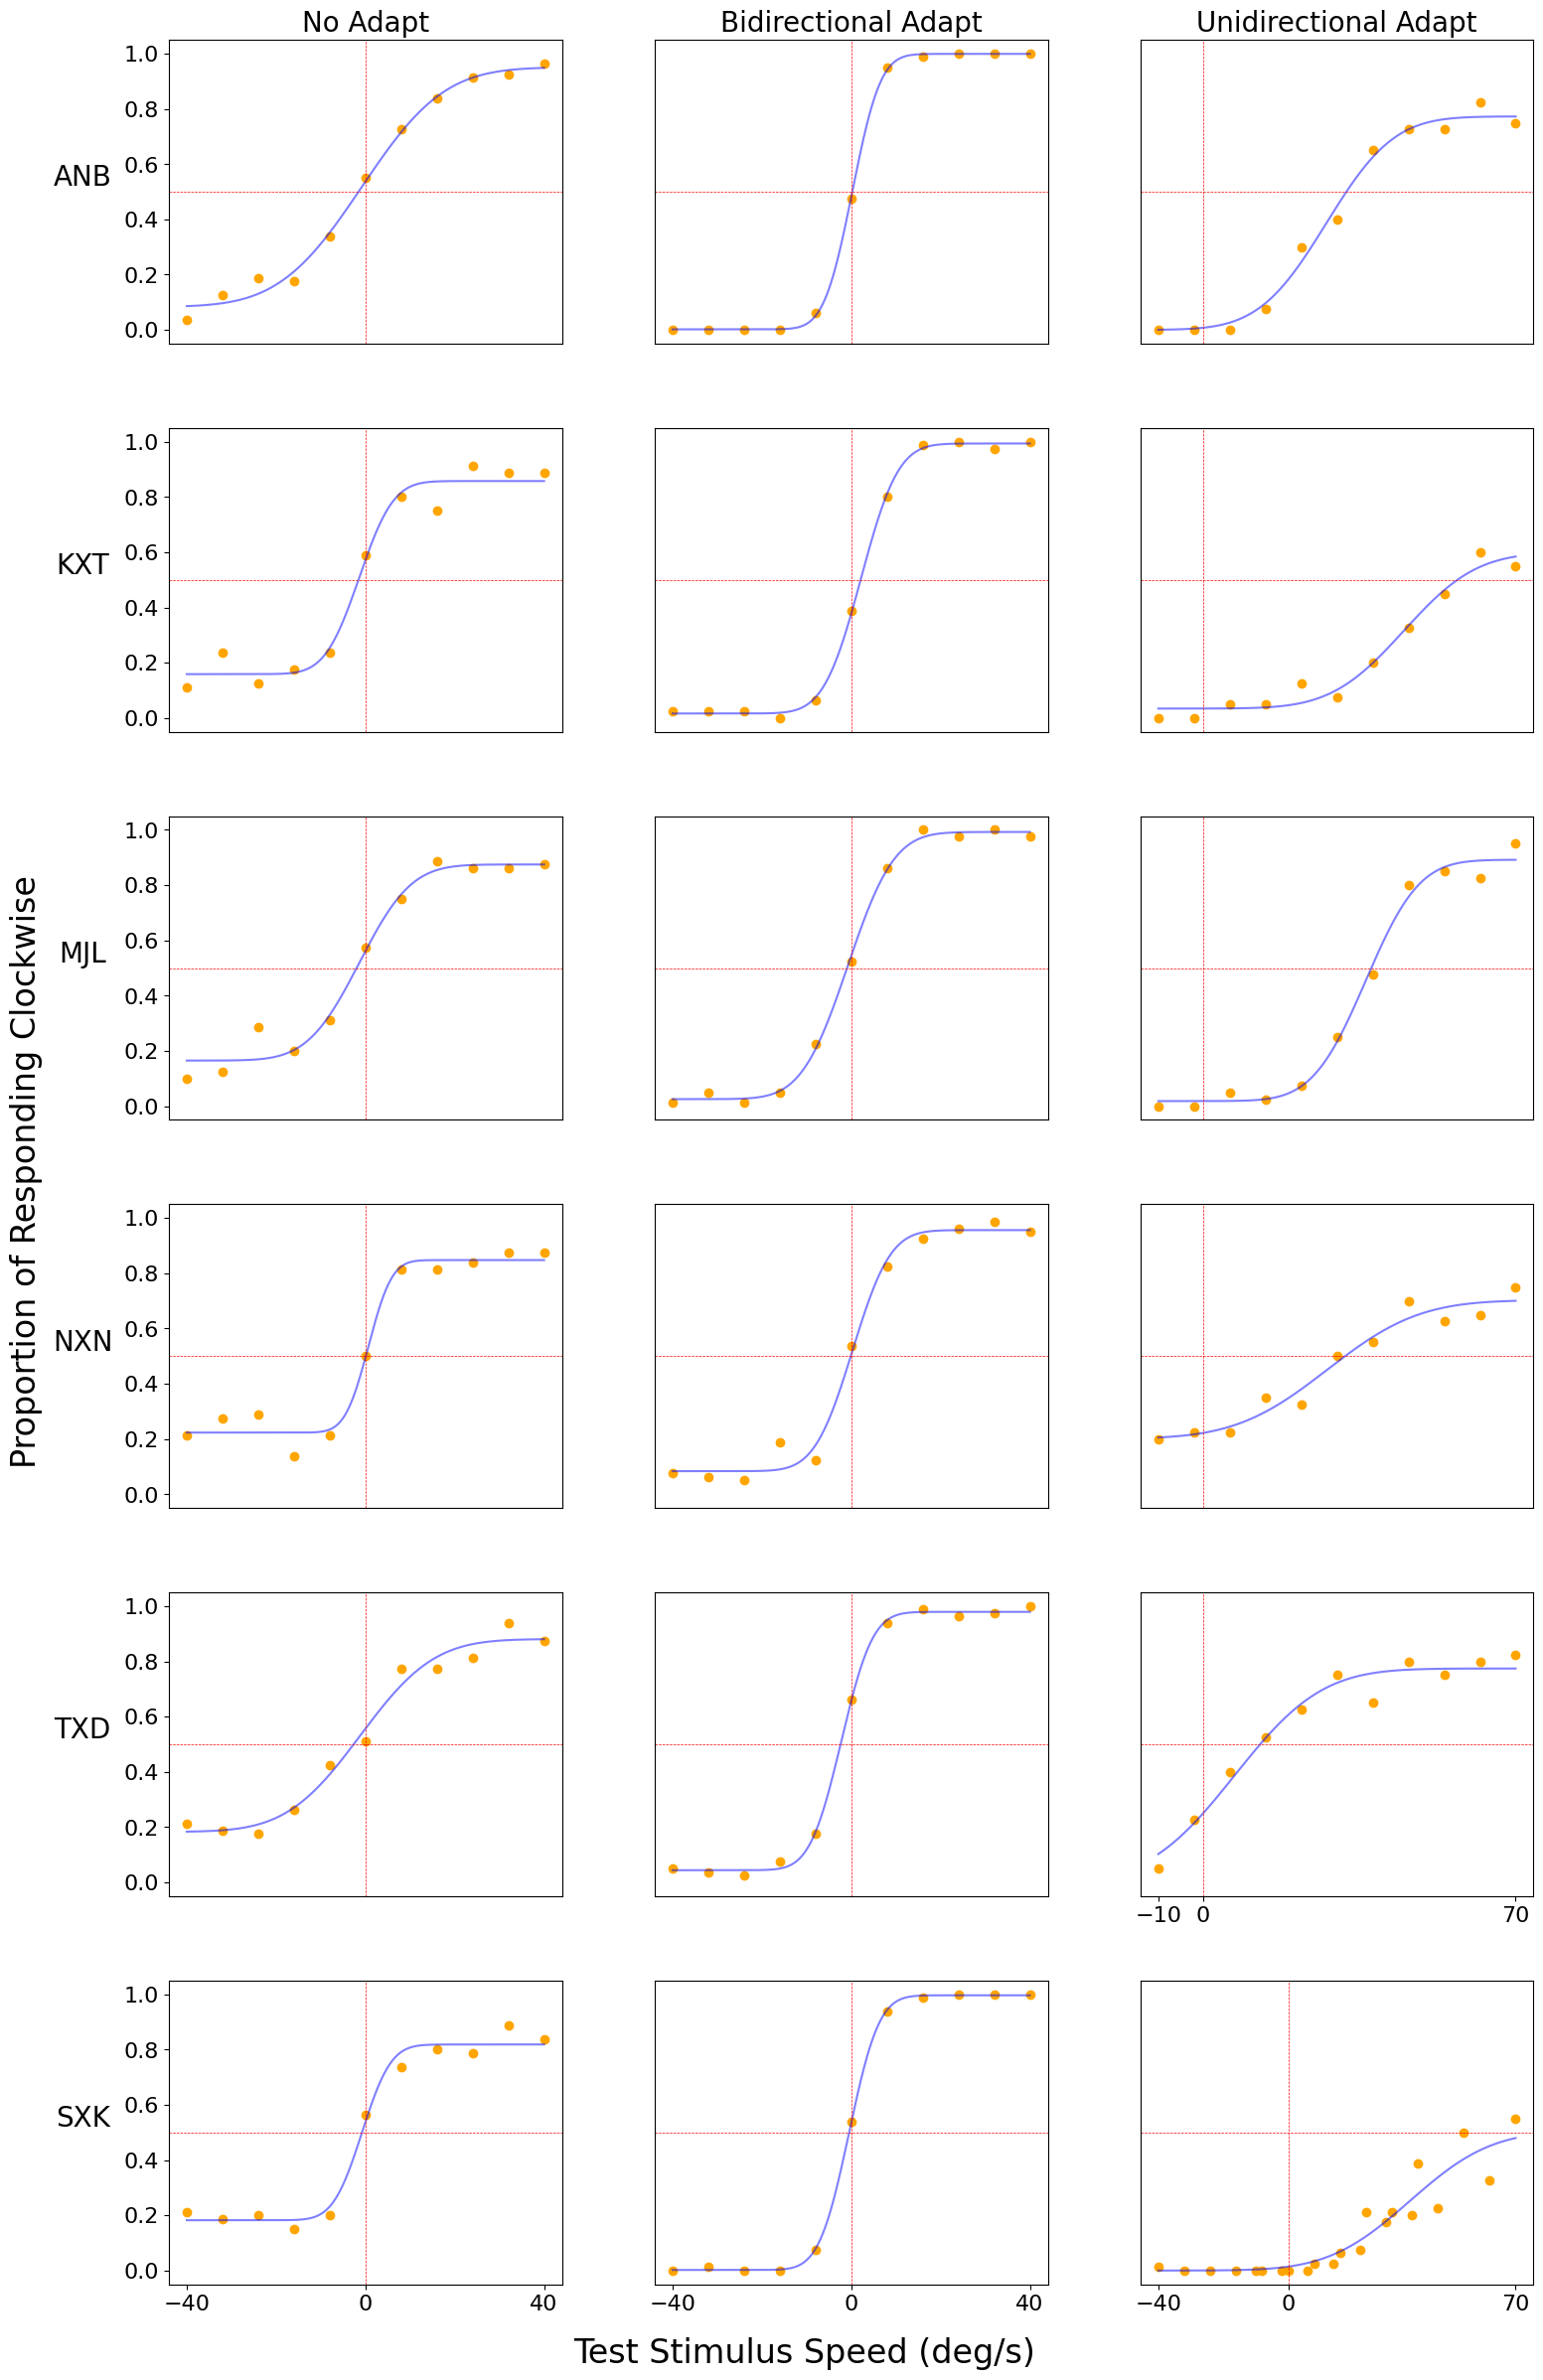

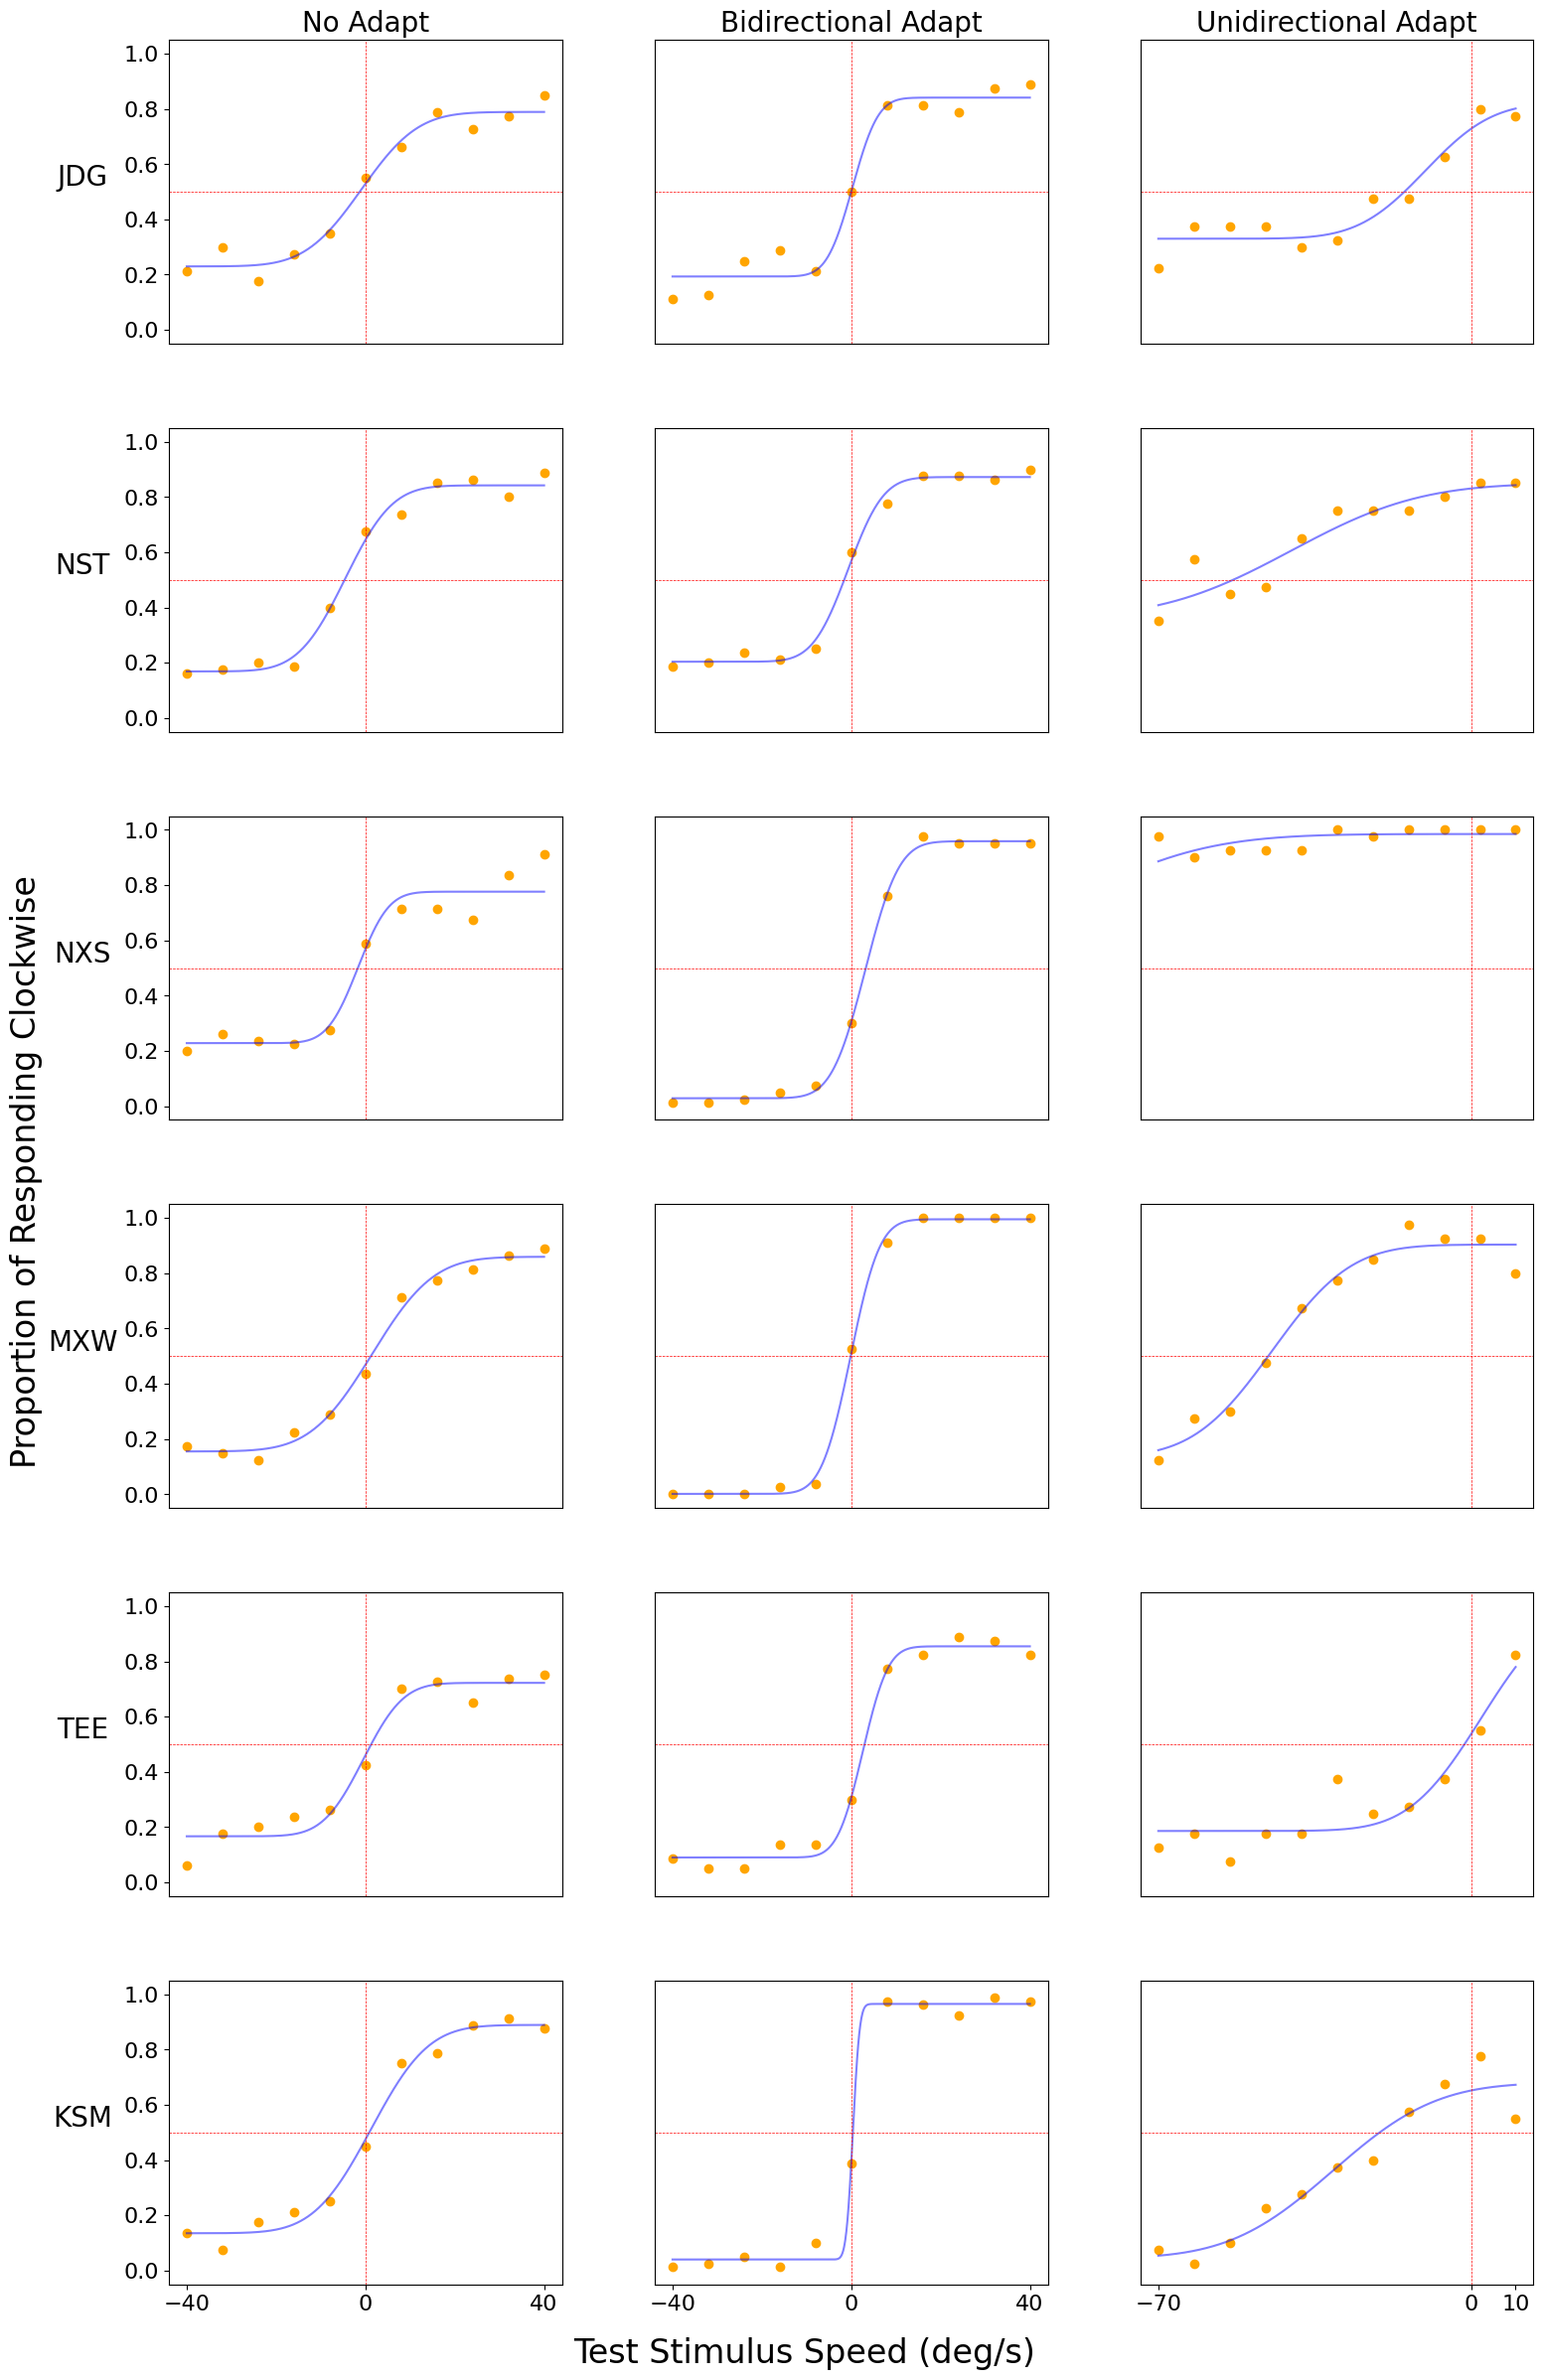

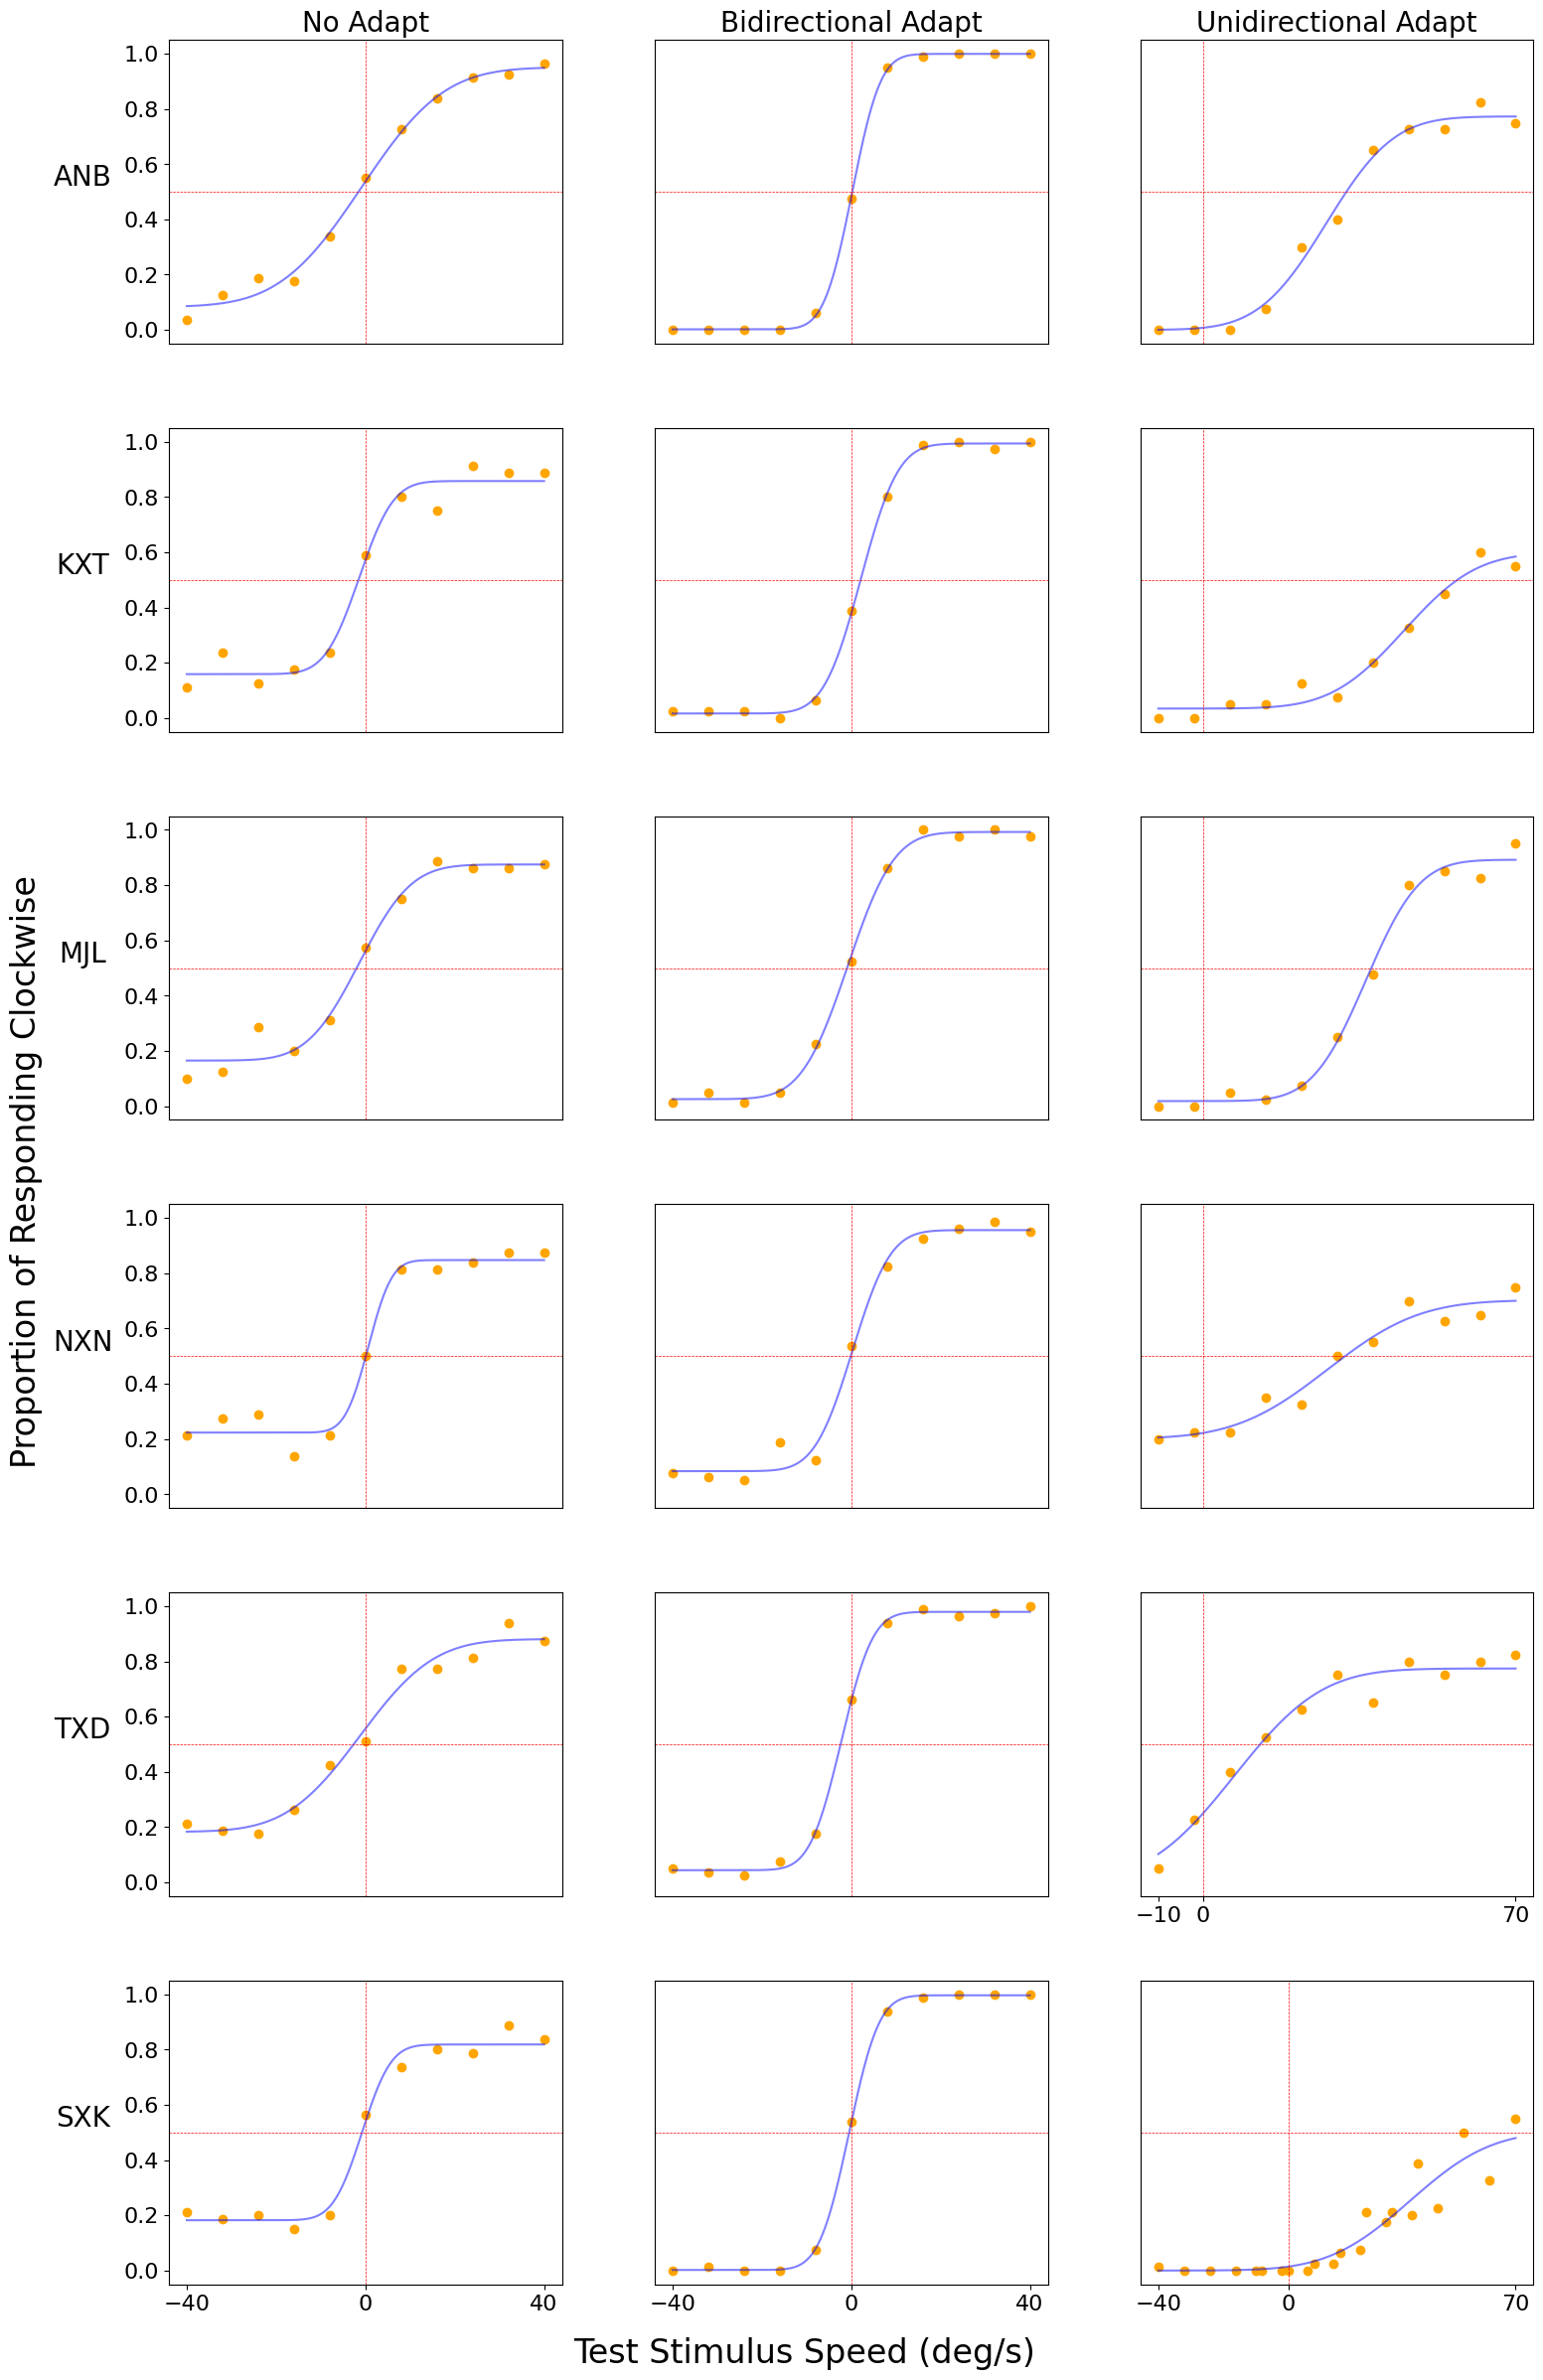

In [318]:
NROWS = 6
NCOLS = 3

output = pd.DataFrame(columns=['Name', 'Exp Type', 'Adapt Direction', 'Mu', 'Sigma', 'Floor', 'Ceiling', 'R^2'])

def plot_psychometric_plot(plot_type):
    fig, ax = plt.subplots(NROWS, NCOLS, figsize=(16,24))
    fig.text(0.5, 0, 'Test Stimulus Speed (deg/s)', ha='center', fontsize=24)
    fig.text(0, 0.5, 'Proportion of Responding Clockwise', va='center', rotation='vertical', fontsize=24)
    fig.tight_layout(pad=4.0)

    for r, subject in enumerate(dirmap[plot_type]):
        for c, condition in enumerate(["No Adapt", "Bidirectional Adapt", "Unidirectional Adapt"]):
            data = combined[(combined["Participant"] == subject) & (combined["Condition"] == condition)]

            responses = data.groupby('Test Speed')['Response']
            count_data = responses.apply(lambda x: x[x.str.contains('right')].count())
            total_counts = responses.count()
            speeds = count_data.index.tolist()

            cw_counts = count_data.tolist()
            cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
            (mu, sigma, a, b), _ = curve_fit(
                f,
                speeds,
                cw_proportions,
                method='dogbox',
                p0=[0, 3, 0, 1],
                bounds=([-90, 0, 0, 0.5], [90, 90, 0.5, 1]),
            )

            pred = f(speeds, mu, sigma, a, b)
            r2 = r2_score(cw_proportions, pred)

            ax[r, c].scatter(speeds, cw_proportions, color='orange', label='Subject Data')

            t = np.linspace(min(speeds), max(speeds), 1000)
            ax[r, c].plot(t, f(t, mu, sigma, a, b), alpha=.5, color='blue', label='Guassian Fit')

            ax[r, c].axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed')
            ax[r, c].axvline(x=0, color='r', linewidth=0.5, linestyle='dashed')
            ax[r, c].set_ylim(-0.05, 1.05)

            ax[r, c].tick_params(axis='both', which='both', labelsize=16)
            if r == 0:
                ax[r, c].set_title(f'{condition}', fontsize=20)
            if c == 0:
                ax[r, c].set_ylabel(f'{subject.upper()}', labelpad=30, rotation=0, fontsize=20)
            if c != 0:
                ax[r, c].set_yticklabels([])
                ax[r, c].set_yticks([])

            if subject.upper() == "TXD" and condition == "Unidirectional Adapt":
                ax[r, c].set_xticks([-10, 0, 70])
            elif subject.upper() == "SXK" and condition == "Unidirectional Adapt":
                ax[r, c].set_xticks([-40, 0, 70])
            elif r < NROWS-1:
                ax[r, c].set_xticklabels([])
                ax[r, c].set_xticks([])
            else:
                match condition:
                    case "Unidirectional Adapt":
                        ticks = [-70, 0, 10] if plot_type == "ccw" else [-10, 0, 70]
                        ax[r, c].set_xticks(ticks)
                    case _:
                        ax[r, c].set_xticks([-40, 0, 40])

            direction = plot_type if condition == "Unidirectional Adapt" else ''
            output.loc[len(output)] = [subject, condition, direction, mu, sigma, a, b, r2]

    plt.subplots_adjust(left=0.1)
    plt.savefig(f"./plots/psychometric_fits_{plot_type}.svg", pad_inches=0.1, bbox_inches='tight')
    return fig

plot_psychometric_plot("ccw")
plot_psychometric_plot("cw")

In [325]:
output.sort_values(by=['Name']).reset_index(drop=True).to_csv("./results/gauss_fits.csv")

## Statistical Analysis

In [320]:
normalized_output = output.copy()
normalized_output['Mu'] = normalized_output['Mu'].where(normalized_output['Adapt Direction'] == 'cw', -normalized_output['Mu'])
normalized_output.rename(columns={'Exp Type': 'ExpType'}, inplace=True)
normalized_output = normalized_output.groupby(['Name', 'ExpType'])[['Sigma', 'Mu']].mean().reset_index()

normalized_output.groupby(['ExpType'])[['Sigma', 'Mu']].mean()

,Sigma,Mu
ExpType,,
Bidirectional Adapt,5.383409,-0.407100
No Adapt,8.607885,0.795532
Unidirectional Adapt,15.705677,32.928173


### Effect of Adaptation on Sensitivity

In [321]:
# Repeated-measures ANOVA for sensitivity following unidirectional adaptation
results = AnovaRM(
    data=normalized_output[(normalized_output['ExpType'] == 'No Adapt') | (normalized_output['ExpType'] == 'Unidirectional Adapt')],
    depvar='Sigma',
    subject='Name',
    within=['ExpType'],
).fit()

results.anova_table

,F Value,Num DF,Den DF,Pr > F
ExpType,13.844865,1.0,11.0,0.003377


In [322]:
# Repeated-measures ANOVA for sensitivity following bidirectional adaptation
results = AnovaRM(
    data=normalized_output[(normalized_output['ExpType'] == 'No Adapt') | (normalized_output['ExpType'] == 'Bidirectional Adapt')],
    depvar='Sigma',
    subject='Name',
    within=['ExpType'],
).fit()

results.anova_table

,F Value,Num DF,Den DF,Pr > F
ExpType,7.614428,1.0,11.0,0.018575


### Effect of Adaptation on Bias

In [323]:
st.wilcoxon(
    normalized_output[normalized_output['ExpType'] == 'No Adapt']['Mu'],
    normalized_output[normalized_output['ExpType'] == 'Unidirectional Adapt']['Mu'],
)

WilcoxonResult(statistic=1.0, pvalue=0.0009765625)

# Bootstrapping Confidence Intervals

Read https://acclab.github.io/bootstrap-confidence-intervals.html for more information.

In [ ]:
def confidence_interval(lst, alpha=0.95):
    return st.t.interval(
        alpha,
        df=len(lst)-1,
        loc=np.mean(lst),
        scale=st.sem(lst),
    )

  0%|          | 0/3 [00:00<?, ?it/s]

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 33%|███▎      | 1/3 [00:57<01:54, 57.16s/it]

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 67%|██████▋   | 2/3 [01:45<00:52, 52.10s/it]

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

100%|██████████| 3/3 [03:02<00:00, 60.82s/it]
/var/folders/38/cyy5p2n96d1fr3wzqvg05w4c0000gn/T/ipykernel_59595/834053293.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([s for s in conditions], fontsize=14)


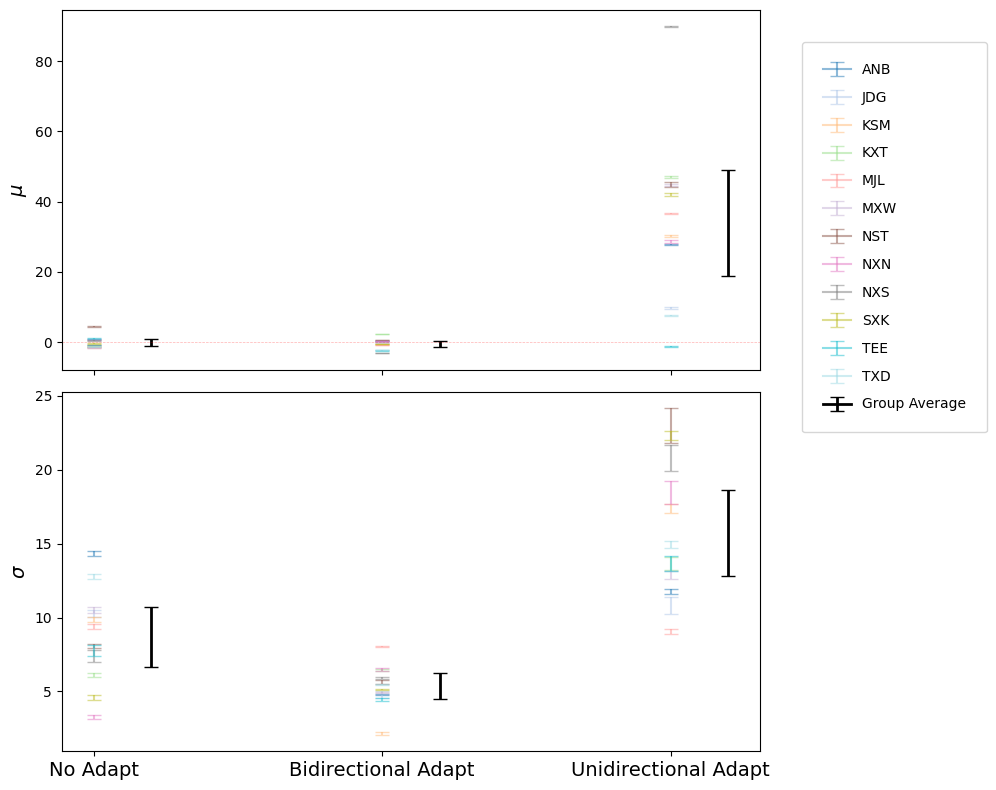

In [ ]:
np.random.seed(0)
N_SAMPLES = 1000

cis = pd.DataFrame(columns=['Name', 'Exp Type', 'Mu CI', 'Sigma CI'])

# Create single figures for mu and sigma
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Create a color map for different subjects
colors = plt.cm.tab20(np.linspace(0, 1, len(subject_list)))
conditions = ["No Adapt", "Bidirectional Adapt", "Unidirectional Adapt"]

for c, condition in enumerate(tqdm(conditions)):
    mu_averages, sigma_averages = [], []
    for i, subject in enumerate(tqdm(subject_list, leave=False)):
        original_data = combined[(combined["Participant"] == subject) & (combined["Condition"] == condition)]
        mus, sigmas = [], []

        k = 0
        while k < N_SAMPLES:
            data = original_data.sample(replace=True, n=len(original_data))

            count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
            total_counts = data.groupby('Test Speed').count()['Response']
            speeds = count_data.index.tolist()

            cw_counts = count_data.tolist()
            cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
            try:
                with np.errstate(divide='ignore'):
                    (mu, sigma, a, b), _ = curve_fit(
                        f,
                        speeds,
                        cw_proportions,
                        method='dogbox',
                        p0=[0, 3, 0, 1],
                        bounds=([-90, 0, 0, 0.5], [90, 90, 0.5, 1]),
                        maxfev=5000,
                    )
            except Exception:
                continue

            mus.append(mu)
            sigmas.append(sigma)
            k += 1

        if reverse_dirmap[subject] == "ccw":
            mus = [-x for x in mus]

        mu_ci = confidence_interval(mus)
        mu_err = (mu_ci[1] - mu_ci[0]) / 2
        sigma_ci = confidence_interval(sigmas)
        sigma_err = (sigma_ci[1] - sigma_ci[0]) / 2

        x_pos = c

        # Plot error bars for subject
        axes[0].errorbar(x_pos, np.mean(mus), yerr=mu_err, alpha=0.5,
                       color=colors[i], capsize=5,
                       label=subject.upper() if c == 0 else None)
        axes[1].errorbar(x_pos, np.mean(sigmas), yerr=sigma_err, alpha=0.5,
                          color=colors[i], capsize=5)

        cis.loc[len(cis)] = [subject, condition, mu_ci, sigma_ci]
        mu_averages.append(np.mean(mus))
        sigma_averages.append(np.mean(sigmas))

    mu_average_ci = confidence_interval(mu_averages)
    mu_average_err = (mu_average_ci[1] - mu_average_ci[0]) / 2
    axes[0].errorbar(c + 0.2, np.mean(mu_averages), yerr=mu_average_err,
                  capsize=5, color='black', linewidth=2,
                  label='Group Average' if c == 0 else None)

    sigma_average_ci = confidence_interval(sigma_averages)
    sigma_average_err = (sigma_average_ci[1] - sigma_average_ci[0]) / 2
    axes[1].errorbar(c + 0.2, np.mean(sigma_averages), yerr=sigma_average_err,
                     capsize=5, color='black', linewidth=2)

axes[0].set_ylabel("$\mu$", fontsize=14)
axes[0].set_xticks(range(len(conditions)))
axes[0].set_xticklabels([])
axes[0].axhline(y=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)

axes[1].set_ylabel("$\sigma$", fontsize=14)
axes[1].set_xticklabels([s for s in conditions], fontsize=14)
axes[1].set_xticks(range(len(conditions)))

fig.tight_layout()
fig.legend(bbox_to_anchor=(1, 0.95), loc='upper left', borderpad=1.5, labelspacing=1)
fig.savefig("./plots/fits_summary.svg", bbox_inches='tight')

In [66]:
cis['Mu CI'] = cis['Mu CI'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
cis['Sigma CI'] = cis['Sigma CI'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
cis.to_csv('./results/ci_data.csv')

In [65]:
cis.head()

,Name,Exp Type,Mu CI,Sigma CI
0,anb,No Adapt,"(-2.054, -1.909)","(19.631, 19.828)"
1,jdg,No Adapt,"(-1.627, -1.41)","(36.871, 37.257)"
2,ksm,No Adapt,"(0.182, 0.323)","(21.376, 21.625)"
3,kxt,No Adapt,"(-1.528, -1.381)","(21.794, 22.094)"
4,mjl,No Adapt,"(-3.341, -3.189)","(23.567, 23.833)"


# Session-Averaged Analysis

This follow the same analysis as in [the previous section](#Psychometric-Function-Fitting), only that instead of fitting on all available data across sessions, we fit on sessions independently, then average the fitted parameters. We also only use two parameters (mu and sigma) in the fitting.

In [273]:
session_data = pd.DataFrame(columns=["Participant","Session","Condition","Response","Test Stim","Test Speed","Correct","Time"])

files = glob.glob('./data/raw/**/*.csv')
for file in files:
    # Skip practice sessions
    if 'practice' in file:
        continue

    filename = file[file.rfind('/')+1:]
    segments = re.split(r'[\-_\.]', filename)
    name = segments[0][:3].lower()
    session = segments[1]

    match file:
        case file if 'unidirectional' in file:
            t_type = 'Unidirectional Adapt'
        case file if 'bidirectional' in file and 'noAdapt' not in file:
            t_type = 'Bidirectional Adapt'
        case _:
            t_type = 'No Adapt'

    participant_data = pd.read_csv(file, index_col=0)
    participant_data["Participant"] = name
    participant_data["Condition"] = t_type
    participant_data["Session"] = session
    session_data = pd.concat([session_data, participant_data], axis=0)

/var/folders/38/cyy5p2n96d1fr3wzqvg05w4c0000gn/T/ipykernel_59595/163163253.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  session_data = pd.concat([session_data, participant_data], axis=0)


In [285]:
session_output = pd.DataFrame(columns=['Name', 'Session', 'Exp Type', 'Adapt Direction', 'Mu', 'Sigma', 'Floor', 'Ceiling', 'R^2'])

def f(x, mu, sigma):
    return st.norm.cdf(x, mu, sigma)

for r, subject in enumerate(subjects):
    for c, condition in enumerate(["No Adapt", "Bidirectional Adapt", "Unidirectional Adapt"]):
        sdata = session_data[(session_data["Participant"] == subject) & (session_data["Condition"] == condition)]
        sessions = sdata["Session"].unique().tolist()

        for session in sessions:
            data = sdata[sdata["Session"] == session]

            responses = data.groupby('Test Speed')['Response']
            count_data = responses.apply(lambda x: x[x.str.contains('right')].count())
            total_counts = responses.count()
            speeds = count_data.index.tolist()

            cw_counts = count_data.tolist()
            cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
            (mu, sigma), _ = curve_fit(
                f,
                speeds,
                cw_proportions,
                method='dogbox',
                p0=[0, 3],
                bounds=([-90, 0], [90, 90]),
            )

            pred = f(speeds, mu, sigma)
            r2 = r2_score(cw_proportions, pred)

            direction = ''
            if condition == "Unidirectional Adapt":
                direction = reverse_dirmap[subject]
            session_output.loc[len(session_output)] = [subject, session, condition, direction, mu, sigma, a, b, r2]

session_output.head()

,Name,Session,Exp Type,Adapt Direction,Mu,Sigma,Floor,Ceiling,R^2
0,mxw,112016,No Adapt,,2.724368,26.846293,0.0,0.589402,0.936953
1,mxw,201813,No Adapt,,-0.772466,24.819616,0.0,0.589402,0.939406
2,mxw,201030,Bidirectional Adapt,,0.314005,4.507663,0.0,0.589402,0.999959
3,mxw,201433,Bidirectional Adapt,,-0.532257,5.784600,0.0,0.589402,0.996104
4,mxw,210459,Unidirectional Adapt,ccw,-45.676033,22.276368,0.0,0.589402,0.942063


In [286]:
normalized_session_output = session_output.copy()
normalized_session_output['Mu'] = normalized_session_output['Mu'].where(normalized_session_output['Adapt Direction'] == 'cw', -normalized_session_output['Mu'])
normalized_session_output.rename(columns={'Exp Type': 'ExpType'}, inplace=True)
normalized_session_output = normalized_session_output.groupby(['Name', 'ExpType'])[['Sigma', 'Mu']].mean().reset_index()

normalized_session_output.groupby(['ExpType'])[['Sigma', 'Mu']].mean()

,Sigma,Mu
ExpType,,
Bidirectional Adapt,10.230393,-0.068778
No Adapt,27.481366,1.174917
Unidirectional Adapt,34.480851,40.866421


In [287]:
results = AnovaRM(
    data=normalized_session_output[(normalized_session_output['ExpType'] == 'No Adapt') | (normalized_session_output['ExpType'] == 'Unidirectional Adapt')],
    depvar='Sigma',
    subject='Name',
    within=['ExpType'],
    aggregate_func='mean',
).fit()

results.anova_table

,F Value,Num DF,Den DF,Pr > F
ExpType,2.963173,1.0,11.0,0.113145


In [288]:
results = AnovaRM(
    data=normalized_session_output[(normalized_session_output['ExpType'] == 'No Adapt') | (normalized_session_output['ExpType'] == 'Bidirectional Adapt')],
    depvar='Sigma',
    subject='Name',
    within=['ExpType'],
    aggregate_func='mean',
).fit()

results.anova_table

,F Value,Num DF,Den DF,Pr > F
ExpType,74.606869,1.0,11.0,0.000003


In [289]:
st.wilcoxon(
    normalized_session_output[normalized_session_output['ExpType'] == 'No Adapt']['Mu'],
    normalized_session_output[normalized_session_output['ExpType'] == 'Unidirectional Adapt']['Mu'],
)

WilcoxonResult(statistic=0.0, pvalue=0.00048828125)

# Aggregated Results

In [82]:
def aggregate_data(condition, subjects=subjects):
    data = combined[(combined['Condition'] == condition) & (combined['Participant'].isin(subjects))]
    responses = data.groupby(['Test Speed', 'Participant'])['Response']
    cw_counts = responses.apply(lambda x: x[x.str.contains('right')].count())
    total_counts = responses.count()

    cw_proportions = (cw_counts / total_counts).groupby(by='Test Speed')
    return cw_proportions.mean(), cw_proportions.sem()

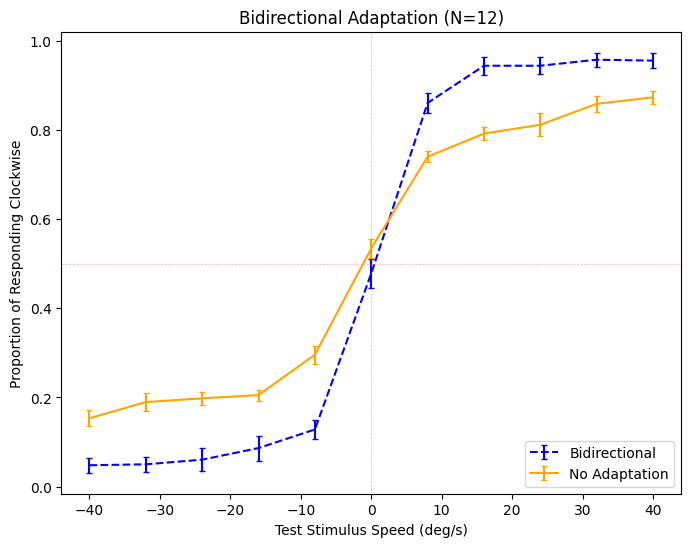

In [109]:
cw_adapt_ccw, sem_adapt_ccw = aggregate_data('Bidirectional Adapt')
cw_noadapt, sem_noadapt = aggregate_data('No Adapt')

plt.figure(figsize=(8, 6))
plt.errorbar(cw_adapt_ccw.index.tolist(), cw_adapt_ccw, yerr=sem_adapt_ccw, linestyle='dashed', label='Bidirectional', c='blue', capsize=2)
plt.errorbar(cw_noadapt.index.tolist(), cw_noadapt, yerr=sem_noadapt, label='No Adaptation', c='orange', capsize=2)

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Bidirectional Adaptation (N={len(subjects)})')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig('./plots/average_bidirectional.svg')

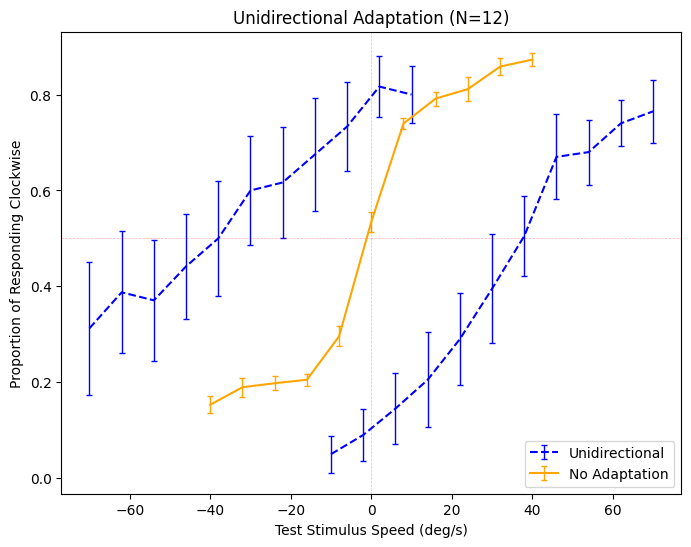

In [111]:
cw_adapt_ccw, sem_adapt_ccw = aggregate_data('Unidirectional Adapt', dirmap["ccw"])
cw_adapt_cw, sem_adapt_cw = aggregate_data('Unidirectional Adapt', [x for x in dirmap["cw"] if x != "sxk"])
cw_noadapt, sem_noadapt = aggregate_data('No Adapt')

plt.figure(figsize=(8, 6))
plt.errorbar(cw_adapt_ccw.index.tolist(), cw_adapt_ccw, yerr=sem_adapt_ccw, linestyle='dashed', label='Unidirectional', c='blue', capsize=2, elinewidth=1)
plt.errorbar(cw_adapt_cw.index.tolist(), cw_adapt_cw, yerr=sem_adapt_cw, linestyle='dashed', c='blue', capsize=2, elinewidth=1)
plt.errorbar(cw_noadapt.index.tolist(), cw_noadapt, yerr=sem_noadapt, label='No Adaptation', c='orange', capsize=2, elinewidth=1)

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Unidirectional Adaptation (N={len(subjects)})')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig('./plots/average_unidirectional.svg')